# Distributed Acoustic Source Localization
## Parameter Definition and Centralized Optimization

**Distributed acoustic source localization problem:**
A network of $10$ sensors collaboratively estimates the unknown source location $\theta_s \in \mathbb{R}^2$.
Each sensor $i$ ($i=1,\ldots,10$), located at a known position $r_i \in \mathbb{R}^2$, collects $15$ measurements modeled as

$$
m_{i,j} = \frac{A}{\lVert \theta_s - r_i \rVert} + \omega_{i,j},
$$

where $A = 100$ is the signal amplitude and $\omega_{i,j} \sim \mathcal{N}(0,1)$ denotes independent measurement noise.

The sensors cooperatively solve the following regularized nonlinear least-squares problem:

$$
\min_{\theta \in \mathbb{R}^2}
\frac{1}{150}\sum_{i=1}^{10}\sum_{j=1}^{15}
\left(m_{i,j} - \frac{A}{\lVert \theta - r_i \rVert}\right)^2
+ \rho \lVert \theta \rVert^2 ,
$$

where $\rho = 10^{-4}$ is an $\ell_2$ regularization parameter.
The optimal centralized solution is denoted by $\hat{s}^*$ and is used as a reference in the distributed experiments.

The communication network is described by a graph with Laplacian matrix $L$.
The gossip (mixing) matrix is defined as

$$
W = I - 0.15 L,
$$

and is used for local information averaging among neighboring sensors.

In [1]:
if __name__ == "__main__":
    import numpy as np
    from scipy.optimize import minimize, OptimizeResult
    from numpy.typing import NDArray
    from numpy.linalg import norm

    # Set parameters for the source localization problem
    A = 100
    src_loc = np.array([10, 40])

    # Sensor locations
    from topolink import Graph, bootstrap

    L = np.array(
        [
            [2, 0, -1, -1, 0, 0, 0, 0, 0, 0],
            [0, 3, -1, 0, 0, -1, 0, -1, 0, 0],
            [-1, -1, 2, 0, 0, 0, 0, 0, 0, 0],
            [-1, 0, 0, 2, 0, 0, 0, 0, 0, -1],
            [0, 0, 0, 0, 1, 0, -1, 0, 0, 0],
            [0, -1, 0, 0, 0, 2, -1, 0, 0, 0],
            [0, 0, 0, 0, -1, -1, 2, 0, 0, 0],
            [0, -1, 0, 0, 0, 0, 0, 2, -1, 0],
            [0, 0, 0, 0, 0, 0, 0, -1, 1, 0],
            [0, 0, 0, -1, 0, 0, 0, 0, 0, 1],
        ]
    )
    W = np.eye(10) - L * 0.15

    graph = Graph.from_mixing_matrix(W, transport="ipc")
    n_sens = graph.number_of_nodes

    np.random.seed(0)
    sens_loc_x = np.random.uniform(-10, 30, n_sens)
    sens_loc_y = np.random.uniform(20, 60, n_sens)
    sens_loc = np.vstack((sens_loc_x, sens_loc_y))

    # Generate the measurements
    n_meas = 15
    meas_var = 1
    meas_normal = A / norm(src_loc[:, np.newaxis] - sens_loc, axis=0)
    meas = meas_normal[np.newaxis, :] + np.random.normal(0, meas_var, (n_meas, n_sens))

    # Regularization parameter
    rho = 0.0001

    # Centralized optimization
    def f_cen(theta: NDArray[np.float64]) -> float:
        res = 0.0

        for i in range(n_sens):
            for j in range(n_meas):
                res = res + (meas[j, i] - A / norm(theta - sens_loc[:, i])) ** 2

        res = res / (n_sens * n_meas) + rho * np.sum(theta**2)

        return res

    result: OptimizeResult = minimize(f_cen, np.array([0, 0]))
    theta_star: NDArray[np.float64] = np.asarray(result.get("x", np.zeros(2)))

    print(f"Centralized solution: {theta_star}")

Centralized solution: [ 9.98745619 40.01921474]


### Global Matplotlib Plotting Parameters and Sensor Color Scheme

In [2]:
if __name__ == "__main__":
    import matplotlib.pyplot as plt
    from matplotlib.colors import BoundaryNorm

    plt.rcParams["text.usetex"] = True  # 使用外部 LaTeX 编译器
    plt.rcParams["font.family"] = "serif"  # 设置字体为 LaTeX 的默认 serif 字体

    plt.rcParams.update(
        {
            "font.size": 14,  # 全局字体大小
            "axes.titlesize": 16,  # 坐标轴标题字体大小
            "axes.labelsize": 16,  # 坐标轴标签字体大小
            "xtick.labelsize": 16,  # x轴刻度标签字体大小
            "ytick.labelsize": 16,  # y轴刻度标签字体大小
            "legend.fontsize": 13,  # 图例字体大小
        }
    )

### Illustration of the Distributed Acoustic Source Localization Scenario

This figure shows the distributed acoustic source localization setup.
The background colormap represents the signal strength field generated by the acoustic source, where warmer colors indicate stronger signal intensity.
Blue dots indicate the locations of the 10 sensors, and the dashed lines illustrate the underlying communication network among sensors.
The red “×” marks the true source location.

This visualization is used to illustrate the experimental setup for evaluating distributed optimization algorithms in a sensor network–based source localization task.

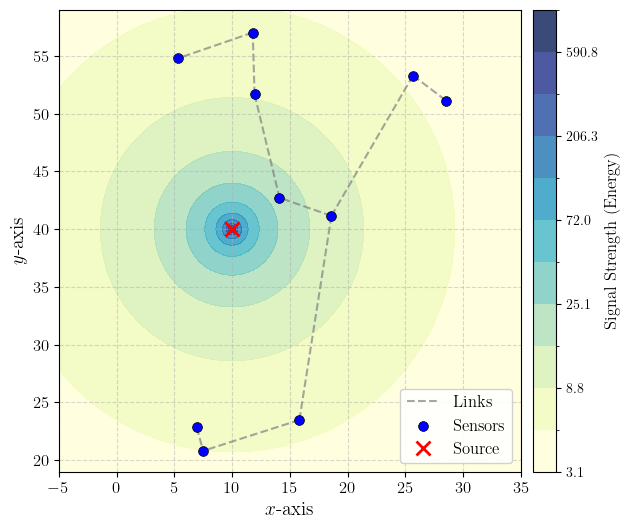

In [3]:
if __name__ == "__main__":
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_aspect(1)
    ax.set_xlim((-5, 35))
    ax.set_ylim((19, 59))
    ax.set_xlabel("$x$-axis", fontsize=14)
    ax.set_ylabel("$y$-axis", fontsize=14)
    ax.tick_params(axis="both", which="major", labelsize=12)

    xx = np.linspace(-5, 35, 1500)
    yy = np.linspace(19, 59, 1500)
    X, Y = np.meshgrid(xx, yy)
    Z = A / np.sqrt((src_loc[0] - X) ** 2 + (src_loc[1] - Y) ** 2)
    Z = np.clip(Z, 0, 1000)

    levels = np.logspace(np.log10(np.min(Z)), np.log10(np.max(Z)), 12)
    cmap = plt.get_cmap("YlGnBu")
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

    contour = ax.contourf(X, Y, Z, levels=levels, cmap=cmap, norm=norm, alpha=0.8)

    cbar = fig.colorbar(contour, ax=ax, pad=0.02)
    cbar.set_label("Signal Strength (Energy)", fontsize=12)
    cbar.ax.tick_params(labelsize=10)

    edge_pairs = [
        (0, 3),
        (3, 9),
        (0, 2),
        (1, 2),
        (1, 7),
        (7, 8),
        (1, 5),
        (5, 6),
        (4, 6),
    ]

    for edge in edge_pairs:
        ax.plot(
            *(sens_loc[:, edge]),
            linestyle="--",
            color="gray",
            linewidth=1.5,
            alpha=0.7,
            label="Links" if edge == edge_pairs[0] else None,
        )

    ax.scatter(
        sens_loc[0, :],
        sens_loc[1, :],
        s=50,
        color="blue",
        label="Sensors",
        edgecolors="black",
        linewidth=0.5,
        zorder=3,
    )

    ax.plot(
        src_loc[0],
        src_loc[1],
        "x",
        color="red",
        label="Source",
        markersize=10,
        markeredgewidth=2,
        zorder=4,
    )

    ax.legend(loc="lower right", fontsize=12, frameon=True, framealpha=0.9)
    ax.grid(visible=True, linestyle="--", alpha=0.5)

## Benchmarking Distributed Optimization Algorithms

In this section, we evaluate the distributed optimization algorithms `RAugDGM`, `RGT`, `WE`, and `RGD` on the acoustic source localization problem.
Each algorithm is run with its corresponding step size.

Performance is measured using the mean squared error (MSE) with respect to the centralized reference solution:

$$
\frac{1}{10 \times 2} \sum_{i=1}^{10} \| \theta_i - \theta^* \|_2^2 ,
$$

where $\theta_i \in \mathbb{R}^2$ denotes the local estimate at sensor $i$, and $\theta^* \in \mathbb{R}^2$ is the centralized optimal solution.
The MSE is reported across iterations.

In [4]:
from multiprocessing import Pool


def nonlinear_least_square(
    node_id: str,
    sens_loc_i: NDArray[np.float64],
    meas_i: NDArray[np.float64],
    dim_i: int,
    a_i: NDArray[np.float64],
    rho_i: int | float,
    gamma: int | float,
    optimizer_name: str,
) -> NDArray[np.float64]:
    from numpy import zeros

    max_iter = 7000
    theta_i = zeros((max_iter, dim_i))

    # Define the loss function
    import jax.numpy as jnp
    from jax import Array

    def f(var: NDArray[np.float64]) -> Array:
        signal_diff = meas_i - a_i / jnp.linalg.norm(var - sens_loc_i)
        regularizer = rho_i * jnp.sum(jnp.square(var))

        return jnp.mean(signal_diff**2) + regularizer

    # Define node handle
    from topolink import NodeHandle
    from topolink.transform import DPMechanism

    transform = DPMechanism(epsilon=1.0, sensitivity=0.01)

    nh = NodeHandle(node_id, transform=transform, transport="ipc")

    # Run optimization
    from dco import get_optimizer

    optimizer = get_optimizer(optimizer_name)(f, nh, gamma)

    optimizer.init(theta_i[0])

    for k in range(max_iter - 1):
        theta_i[k + 1] = optimizer.step(theta_i[k])

    return theta_i


if __name__ == "__main__":
    # Distributed optimization
    step_sizes = {
        "RAugDGM": 0.085,
        "AtcWE": 0.061,
        "WE": 0.050,
        "RGT": 0.039,
        "EXTRA": 0.051,
        "NIDS": 0.061,
        "DIGing": 0.039,
        "AugDGM": 0.085,
    }
    theta_by_algorithm: dict[str, list[NDArray[np.float64]]] = {}

    with Pool() as pool:
        for alg, gam in step_sizes.items():
            bootstrap(graph)

            tasks = [
                pool.apply_async(
                    nonlinear_least_square,
                    args=(f"{i + 1}", sens_loc[:, i], meas[:, i], 2, A, rho, gam, alg),
                )
                for i in range(n_sens)
            ]

            theta_by_algorithm[alg] = [task.get() for task in tasks]

            print(f"Algorithm: {alg}, Step size: {gam}, Finished!")

Algorithm: RAugDGM, Step size: 0.085, Finished!
Algorithm: AtcWE, Step size: 0.061, Finished!
Algorithm: WE, Step size: 0.05, Finished!
Algorithm: RGT, Step size: 0.039, Finished!
Algorithm: EXTRA, Step size: 0.051, Finished!
Algorithm: NIDS, Step size: 0.061, Finished!
Algorithm: DIGing, Step size: 0.039, Finished!
Algorithm: AugDGM, Step size: 0.085, Finished!


## Plot results

### MSE for robust algorithms `RAugDGM`, `RGT`, `WE`, and `RGT`

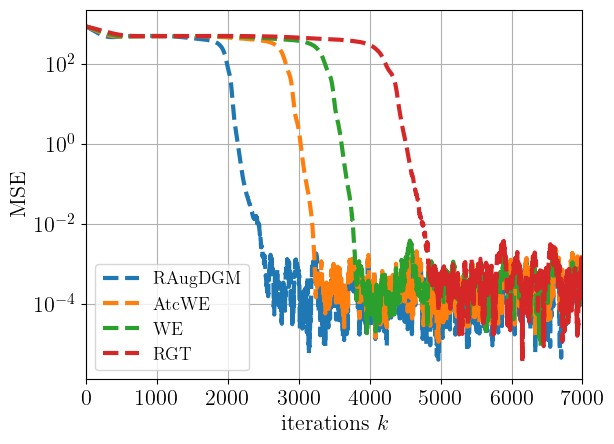

In [7]:
if __name__ == "__main__":
    fig, ax = plt.subplots()
    ax.set_xlim((0, 7000))
    ax.set_xlabel("iterations $k$")
    ax.set_ylabel("MSE")

    line_options = {"linewidth": 3, "linestyle": "--"}

    robust_algorithms = ["RAugDGM", "AtcWE", "WE", "RGT"]
    for alg in robust_algorithms:
        # shape: (n_nodes, n_iter, dim)
        stacked_theta = np.stack(theta_by_algorithm[alg])
        # shape: (n_nodes, n_iter)
        mse_evolution_by_node = np.mean((stacked_theta - theta_star) ** 2, axis=2)
        mse_evolution = np.mean(mse_evolution_by_node, axis=0)
        ax.semilogy(mse_evolution, label=alg, **line_options)

    ax.legend(loc="lower left")
    ax.grid(True, which="major", linestyle="-", linewidth=0.8)

    import pathlib

    fig_dir = pathlib.Path.cwd().parent / "docs" / "figures" / "source_localization"
    fig_dir.mkdir(parents=True, exist_ok=True)

    fig.savefig(fig_dir / "source_localization_mse.png", dpi=300, bbox_inches="tight")
    fig.savefig(fig_dir / "source_localization_mse.pdf", bbox_inches="tight", format="pdf")

### MSE for `RAugDGM` and non-robust algorithms `EXTRA`, `AugDGM`, `NIDS`, and `DIGing`

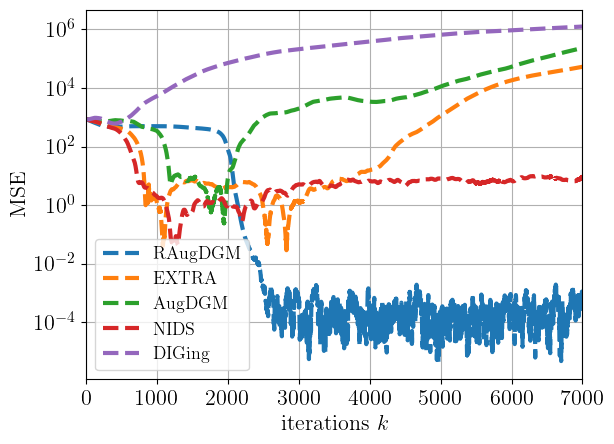

In [8]:
if __name__ == "__main__":
    fig, ax = plt.subplots()
    ax.set_xlim((0, 7000))
    ax.set_xlabel("iterations $k$")
    ax.set_ylabel("MSE")

    line_options = {"linewidth": 3, "linestyle": "--"}

    nonrobust_algorithms = ["RAugDGM", "EXTRA", "AugDGM", "NIDS", "DIGing"]
    for alg in nonrobust_algorithms:
        # shape: (n_nodes, n_iter, dim)
        stacked_theta = np.stack(theta_by_algorithm[alg])
        # shape: (n_nodes, n_iter)
        mse_evolution_by_node = np.mean((stacked_theta - theta_star) ** 2, axis=2)
        mse_evolution = np.mean(mse_evolution_by_node, axis=0)
        ax.semilogy(mse_evolution, label=alg, **line_options)

    ax.legend(loc="lower left")
    ax.grid(True, which="major", linestyle="-", linewidth=0.8)

    fig.savefig(fig_dir / "source_localization_mse_nonrobust.png", dpi=300, bbox_inches="tight")
    fig.savefig(fig_dir / "source_localization_mse_nonrobust.pdf", bbox_inches="tight", format="pdf")